In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line

C:\Users\Luka\AppData\Local\Temp\ipykernel_3180\2772924476.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import numpy as np

In [3]:
file_path = "final_dataset_b2b.csv"
data = pd.read_csv(file_path)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63160893 entries, 0 to 63160892
Data columns (total 16 columns):
 #   Column                                         Dtype  
---  ------                                         -----  
 0   date_order                                     object 
 1   date_invoice                                   object 
 2   product_id                                     int64  
 3   client_id                                      int64  
 4   sales_net                                      float64
 5   quantity                                       int64  
 6   branch_id                                      int64  
 7   product_price                                  float64
 8   order_channel_at the store                     bool   
 9   order_channel_by phone                         bool   
 10  order_channel_during the visit of a sales rep  bool   
 11  order_channel_online                           bool   
 12  order_channel_other                     

In [5]:
num_unique_clients = data['client_id'].nunique()

print("Number of unique client IDs:", num_unique_clients)

Number of unique client IDs: 142436


### Add Churn Labels

##### Devision of df to prevent data leakage

In [6]:
data['date_order'] = pd.to_datetime(data['date_order'])

# Create a random subset of 10% of clients
random_clients = data['client_id'].unique()
np.random.seed(23)
np.random.shuffle(random_clients)
random_clients_subset = random_clients[:int(0.1 * len(random_clients))]

# Create DataFrames for the random subset and the remaining clients
random_subset_df = data[data['client_id'].isin(random_clients_subset)].copy()
remaining_clients_df = data[~data['client_id'].isin(random_clients_subset)].copy()

In [7]:
data_for_rfm = remaining_clients_df

In [8]:
# Find the latest purchase date for each client in the random subset
latest_purchase_dates = data_for_rfm.groupby('client_id')['date_order'].max().reset_index()

# Calculate the difference in days from each client's latest purchase to the entire dataset's latest purchase
latest_dataset_purchase_date = data_for_rfm['date_order'].max()
latest_purchase_dates['latest_purchase_days'] = (latest_dataset_purchase_date - latest_purchase_dates['date_order']).dt.days

In [9]:
# Merge the calculated values back into the random subset DataFrame
data_for_rfm = pd.merge(data_for_rfm, latest_purchase_dates[['client_id', 'latest_purchase_days']], on='client_id', how='left')

# Filter out rows where 'time_diff' is 0 before calculating mean and std
filtered_data_for_rfm = data_for_rfm[data_for_rfm['time_diff'] != 0]

# Calculate mean and std for each unique client based on 'time_diff_numeric'
client_stats = filtered_data_for_rfm.groupby('client_id')['time_diff'].agg(['mean', 'std']).reset_index()

# Merge the client-specific statistics back into the random subset DataFrame
data_for_rfm = pd.merge(data_for_rfm, client_stats, on='client_id', how='left')

# Rename columns for clarity
data_for_rfm.rename(columns={'mean': 'purchase_frequency', 'std': 'std_time_diff'}, inplace=True)

In [10]:
# Add a new column "churned" based on the conditions
data_for_rfm['churned'] = 0  # Initialize with 0 for all rows
data_for_rfm.loc[data_for_rfm['latest_purchase_days'] > (1.5 * data_for_rfm['std_time_diff'] + data_for_rfm['purchase_frequency']), 'churned'] = 1

In [11]:
data_for_rfm.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,branch_id,product_price,order_channel_at the store,order_channel_by phone,order_channel_during the visit of a sales rep,order_channel_online,order_channel_other,time_diff,mean_purchase_frequency_days,cluster,latest_purchase_days,purchase_frequency,std_time_diff,churned
0,2019-08-13,2019-08-13,1650826,6,60.858000,3,8470,20.286000,False,True,False,False,False,NaN,55,2,40,54.583333,66.839643,0
1,2019-07-31,2019-07-31,942611,6,41.538000,3,8470,13.846000,True,False,False,False,False,13.0,55,2,40,54.583333,66.839643,0
2,2019-07-31,2019-07-31,113967,6,63.673200,3,8470,21.224400,True,False,False,False,False,0.0,55,2,40,54.583333,66.839643,0
3,2019-07-31,2019-07-31,1522271,6,370.653924,401,8470,0.924324,True,False,False,False,False,0.0,55,2,40,54.583333,66.839643,0
4,2019-07-25,2019-07-25,1650826,6,60.858000,3,8470,20.286000,False,True,False,False,False,6.0,55,2,40,54.583333,66.839643,0


In [12]:
# Count the number of unique client IDs who have churned
num_unique_churned = data_for_rfm[data_for_rfm['churned'] == 1]['client_id'].nunique()

print(f"The number of unique client IDs who have churned is: {num_unique_churned}")

The number of unique client IDs who have churned is: 38593


In [13]:
# Count the number of unique client IDs who have churned
num_unique_churned = data_for_rfm[data_for_rfm['churned'] == 0]['client_id'].nunique()

print(f"The number of unique client IDs who have churned is: {num_unique_churned}")

The number of unique client IDs who have churned is: 89600


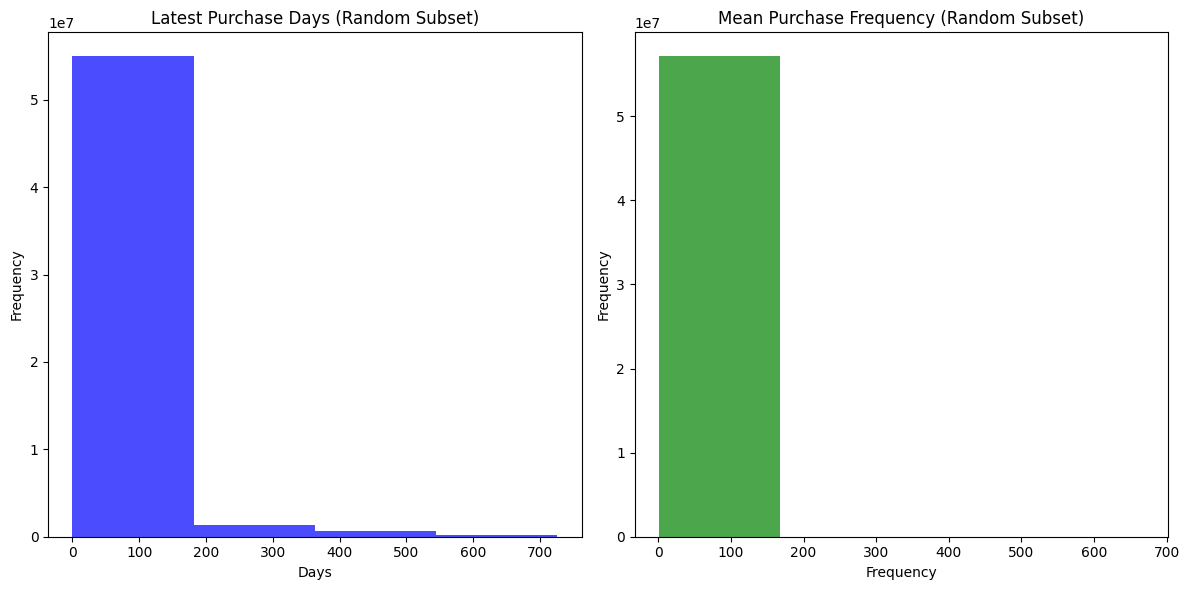

In [14]:
import matplotlib.pyplot as plt
# For random_subset_df
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data_for_rfm['latest_purchase_days'], bins=4, color='blue', alpha=0.7)
plt.title('Latest Purchase Days (Random Subset)')
plt.xlabel('Days')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data_for_rfm['purchase_frequency'], bins=4, color='green', alpha=0.7)
plt.title('Mean Purchase Frequency (Random Subset)')
plt.xlabel('Frequency')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Download Dataset with Churn Labels

In [15]:
random_subset_df.to_csv('final_dataset_b2b_random_subset_churn.csv', index=False)

In [16]:
columns_to_drop = ['time_diff', 'mean_purchase_frequency_days', 'cluster', "branch_id", "product_id", "date_invoice"]
data_for_rfm.drop(columns=columns_to_drop, inplace=True)

In [17]:
data_for_rfm.to_csv('final_dataset_b2b_remaining_clients_churn.csv', index=False)